# SQAE with DRC 

The SQAE with DRC applied to the quark gluon dataset.

### imports 

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from pennylane.optimize import AdamOptimizer
import h5py
from sklearn.model_selection import train_test_split
from hep_VQAE import QAE_pennylane as pQAE

import warnings
warnings.filterwarnings('ignore')

2022-09-24 00:41:00.779452: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-24 00:41:00.779468: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### data 

get small dataset from the data directory

In [2]:
test = h5py.File("../data/small_quark_gluon_12","r")

x_s = test.get('X')
y_s = test.get('y')

split the dataset into train test and validation

In [3]:
x_train, x_val, y_train, y_val = train_test_split(x_s[:],
                                                  y_s[:],
                                                  test_size=0.2, shuffle=True)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train,
                                                    test_size=0.4, shuffle=True)

seperate quarks (1) form gluons (0)

In [4]:
x_train_1 = x_train[y_train==1]
x_train = x_train[y_train==0]

x_val_1 = x_val[y_val==1]
x_val = x_val[y_val==0]

x_test_1 = x_test[y_test==1]
x_test = x_test[y_test==0]

I normalize the images by dividing all pixels by the largest pixel value of the respective image

In [5]:
div = np.max(x_train_1,axis=(1,2)).reshape(x_train_1.shape[0],1,1)
div[div == 0] = 1
x_train_1 = x_train_1 / div
div = np.max(x_train,axis=(1,2)).reshape(x_train.shape[0],1,1)
div[div == 0] = 1
x_train = x_train / div

div = np.max(x_val_1,axis=(1,2)).reshape(x_val_1.shape[0],1,1)
div[div == 0] = 1
x_val_1 = x_val_1 / div
div = np.max(x_val,axis=(1,2)).reshape(x_val.shape[0],1,1)
div[div == 0] = 1
x_val = x_val / div

div = np.max(x_test_1,axis=(1,2)).reshape(x_test_1.shape[0],1,1)
div[div == 0] = 1
x_test_1 = x_test_1 / div
div = np.max(x_test,axis=(1,2)).reshape(x_test.shape[0],1,1)
div[div == 0] = 1
x_test = x_test / div

create smaller sets to limit training time

In [6]:
x_train_small = x_train[:5000]
x_train_1_small = x_train_1[:5000]
x_test_small = x_test[:1200]
x_test_1_small = x_test_1[:1200]

### settings

In [7]:
LATENT_QBITS = 4
DRCs = 2
EPOCHS = 3

DATA_QBITS = 9
TRASH_QBITS = DATA_QBITS - LATENT_QBITS
TOTAL_QBITS = DATA_QBITS + TRASH_QBITS + 1

INPUT_DATA_SIZE = 12

### Circuit

Use lightning qubit as backend

In [8]:
dev1 = qml.device('lightning.qubit', wires=TOTAL_QBITS)

we use kernel size 4 and stride 4 to get the 12x12 image on 9 qubits

In [9]:
model = pQAE.ConvSQAE(DATA_QBITS,
                      LATENT_QBITS, 
                      dev1, 
                      INPUT_DATA_SIZE, 
                      kernel_size=4, 
                      stride=4, 
                      DRCs=DRCs, 
                      diff_method="adjoint")

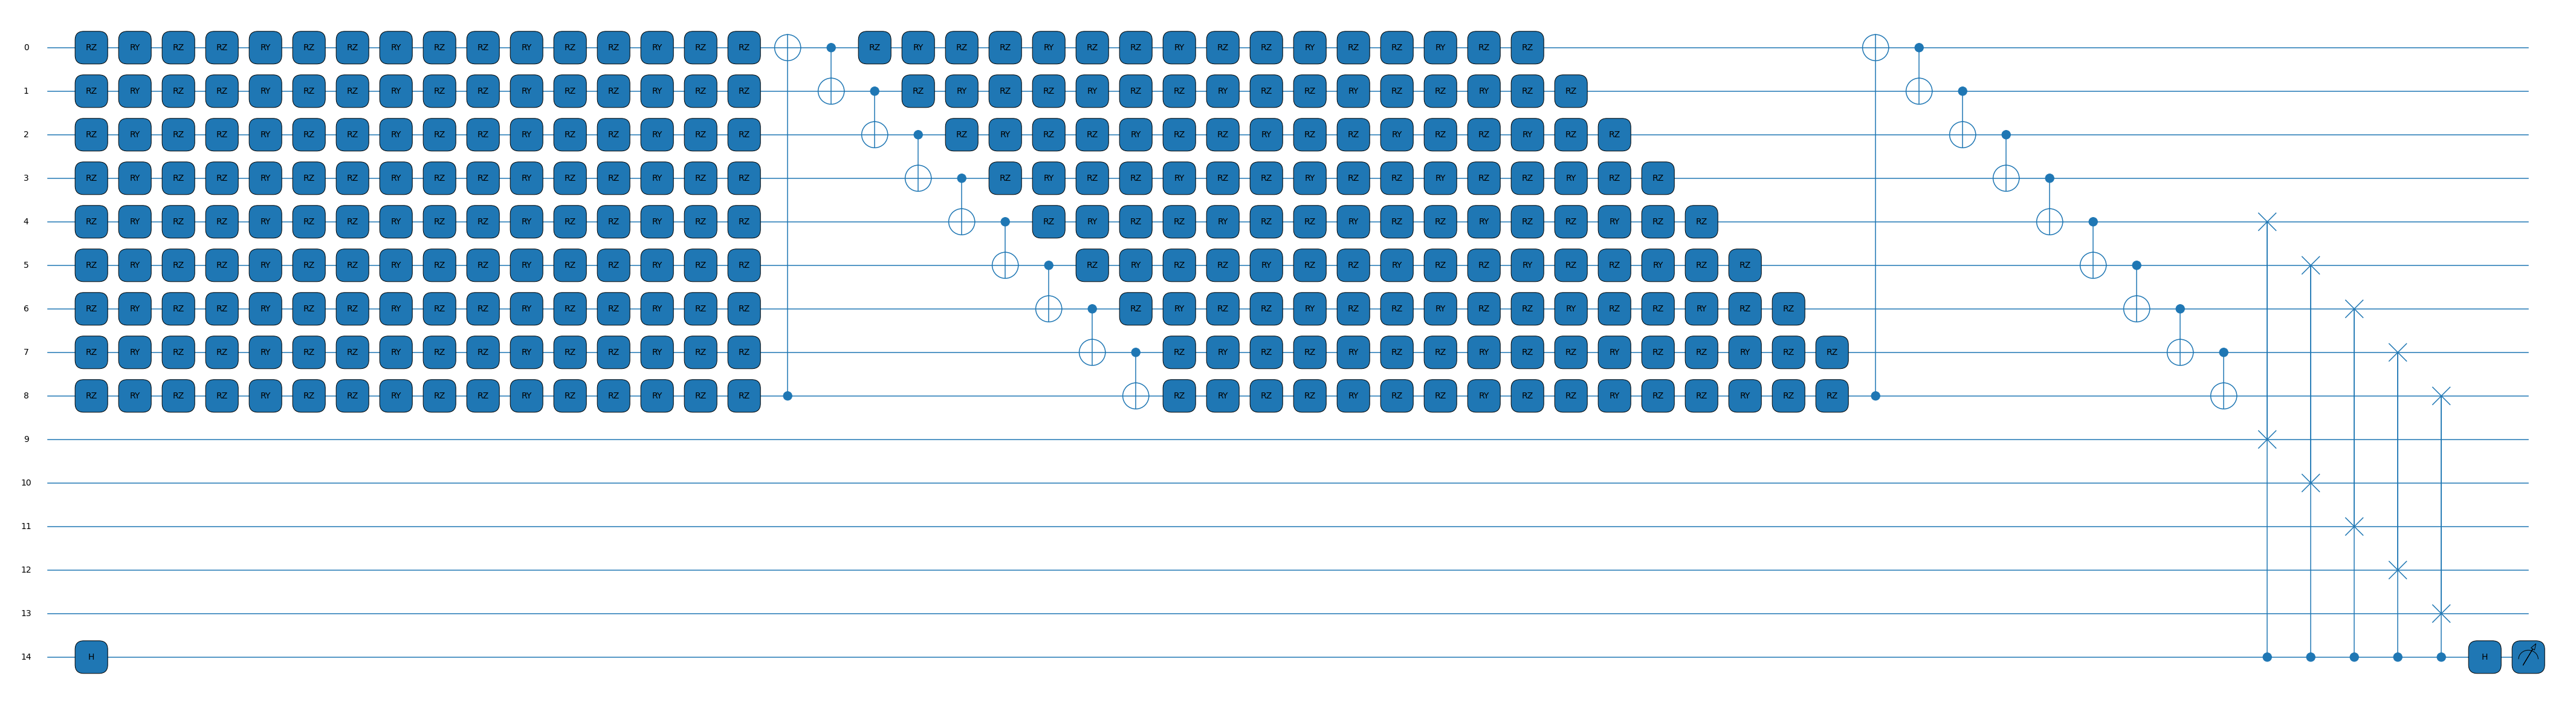

In [10]:
model.plot_circuit()

## training

In [11]:
model.train(x_train_1_small, x_test_1_small, 
            learning_rate=0.004, 
            epochs=EPOCHS, 
            batch_size=30, 
            print_step_size=50, 
            make_animation=False,
            save_auc=True,
            x_val_signal=x_test_small)

Step: 50      | Loss: 0.0547     | avg step time 5.04 | auc: 0.56 | avg gradient 0.492
Step: 100     | Loss: 0.00512    | avg step time 4.51 | auc: 0.561 | avg gradient 0.472
Step: 150     | Loss: 0.00236    | avg step time 3.76 | auc: 0.561 | avg gradient 0.461
____
Epoch: 0     | Loss: 0.00221    | Val Loss 0.00214
____
Step: 50      | Loss: 0.00185    | avg step time 4.32 | auc: 0.562 | avg gradient 0.449
Step: 100     | Loss: 0.00137    | avg step time 3.76 | auc: 0.561 | avg gradient 0.441
Step: 150     | Loss: 0.000826   | avg step time 3.81 | auc: 0.562 | avg gradient 0.434
____
Epoch: 1     | Loss: 0.000843   | Val Loss 0.000817
____
Step: 50      | Loss: 0.000748   | avg step time 3.84 | auc: 0.563 | avg gradient 0.426
Step: 100     | Loss: 0.000601   | avg step time 3.77 | auc: 0.563 | avg gradient 0.421
Step: 150     | Loss: 0.000394   | avg step time 3.78 | auc: 0.563 | avg gradient 0.415
____
Epoch: 2     | Loss: 0.000413   | Val Loss 0.000405
____
Time for 3 epochs: 3990.

## Evaluation

Median fidelities bg:  0.994852613720762
Median fidelities signal:  0.9930287222729751
Median background: 0.00515
Median signal: 0.00697
Maximum accuracy: 0.551
AUC: 0.5631


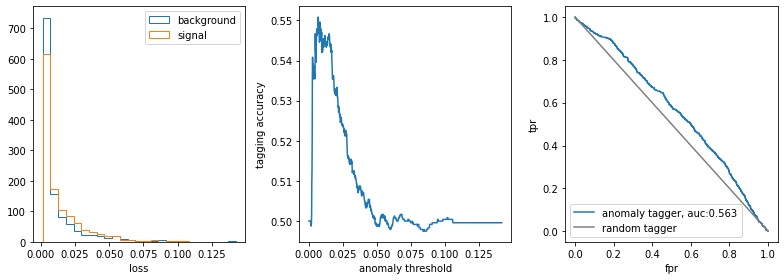

In [12]:
model.evaluate(x_test_1_small, x_test_small)

In [13]:
model.auc_hist

[0.5599315972222222,
 0.5606197916666666,
 0.5613600694444445,
 0.561928125,
 0.5612371527777777,
 0.5615232638888888,
 0.5632697916666667,
 0.5625086805555556,
 0.5625288194444444]

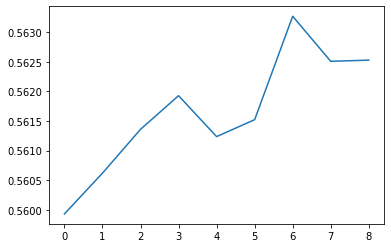

In [14]:
plt.plot(model.auc_hist)

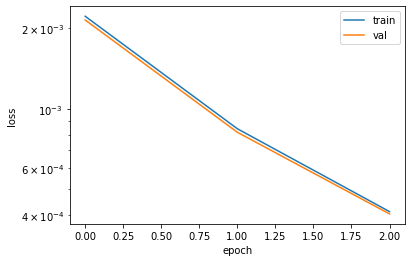

In [15]:
model.plot_train_hist(logscale=True)

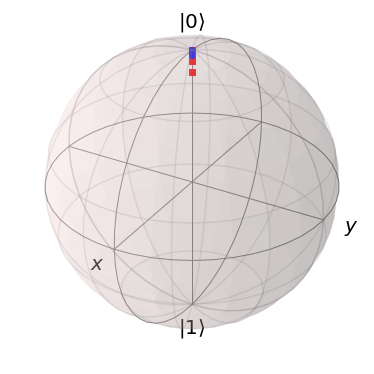

In [19]:
model.plot_latent_space(5,x_test_1_small[:25],x_test_small[:25])